Iterative SLS example with nonlinear dynamics for the state [joint_pos, joint_vel, end_pos, end_vel] and the control [joint_acc] with a quadratic cost.

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os
from matplotlib.transforms import Affine2D

from isls import iSLS
from isls.utils import get_double_integrator_AB
from isls.projections import *
from isls.plot_utils import  plot_car

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
from matplotlib import rc
from matplotlib.animation import FuncAnimation
rc('animation', html='html5')

### Problem parameters 

In [65]:
x_dim = 4
u_dim = 2 
T = 15.
horizon = 500
N = horizon
dt = T/N
print("dt:", dt)
d = x_dim
sls = iSLS(d, u_dim, N)

dt: 0.03


#### Forward model f(x, u) and its jacobian get_AB(x, u)

In [66]:
# Dynamics functions
# x = [x_r, y_r, theta, v]
# u = [steering_angle, dv]
car_length=2. # Size of the car
l = car_length
def f(x, u):
    x1  = x[:, 0:1]  + dt * x[:, 3:4] * np.cos(x[:, 2:3])
    x2  = x[:, 1:2]  + dt * x[:, 3:4] * np.sin(x[:, 2:3])
    x3  = x[:, 2:3]  + dt * x[:, 3:4] * u[:, 0:1]
    x4  = x[:, 3:4]  + dt * u[:, 1:2]
    
    # Make theta stay inside [0, 2*pi]:
    x3 = x3%(2*np.pi)
    return np.concatenate([x1, x2, x3, x4],axis=-1)

def get_AB(x, u):
    A = np.tile(np.eye(d)[None], (N,1,1))
    B = np.zeros((N, d,u_dim))
    
    A[:, 0,2]  = dt * x[:, 3] * -np.sin(x[:, 2])
    A[:, 1,2]  = dt * x[:, 3] *  np.cos(x[:, 2])
    
    A[:, 0,3]  = dt * np.cos(x[:, 2])
    A[:, 1,3]  = dt * np.sin(x[:, 2])
    
    A[:, 2,3] = dt * u[:, 0]

    B[:, 2,0] = dt * x[:, 3]
    B[:, 3,1] = dt

    return A,B

sls.forward_model = f

#### Task definition

In [239]:
u_std=1e-2
x_std_r = 0
x_std = 1e2
x_final_target =np.array([-5., -5., np.pi/4, 0])
# x_final_target = np.zeros(d)
# viaQ_final = np.diag([50., 50., 50., 50.])
viaQ_final = np.diag([x_std]*d)

free_state = np.zeros(d)
# viaQ_free = np.diag([0]*d)
viaQ_free = np.diag([x_std_r]*2 + [0]*2)


zs = np.stack([free_state,  x_final_target])
Qs = np.stack([viaQ_free,  viaQ_final])

seq = np.zeros(N, dtype=np.int32)
seq[-1] = 1

In [240]:
# Set the cost variables if quadratic cost
sls.set_cost_variables(zs, Qs, seq, u_std)

### Solve the unconstrained problem

In [308]:
# initial guess
u0 = np.random.normal(size=(N, u_dim))*0.
x0 = np.zeros(d)
x0 = np.array([0, -2, np.pi/2, 0])
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]

In [309]:
sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom
dp=0
print(sls.cost)

3461.6850275068086


In [310]:
%%time
# Solve
sls.solve_ilqr(get_AB, max_ilqr_iter=50, max_line_search_iter=40, dp=dp, verbose=False)
print(sls.cost_log)

Forward pass failed, cannot improve anymore at iteration 32 .
[3461.6850275068086, 2561.6957512123436, 979.6458536124652, 402.1056829702219, 123.94493387404306, 1.2075192046987118, 1.1463593864880859, 1.0545548973327363, 0.8457512028613352, 0.6140981249834349, 0.6056603598286543, 0.5968940073790631, 0.5890362971626307, 0.5814967408770173, 0.5749168419141112, 0.5689006599477557, 0.5634348095987908, 0.5574409569852171, 0.5509599974393524, 0.5456776121773932, 0.5417931324786712, 0.5388381750320553, 0.5362799326806836, 0.5340486257251329, 0.5321979491396382, 0.5307105616607884, 0.5294630069858678, 0.5285342654289813, 0.5280986898320933, 0.527912701273816, 0.5278417600575158, 0.5278239249702645]
Wall time: 4.99 s


[-4.99933e+00 -5.00166e+00  7.84089e-01  8.89766e-04]


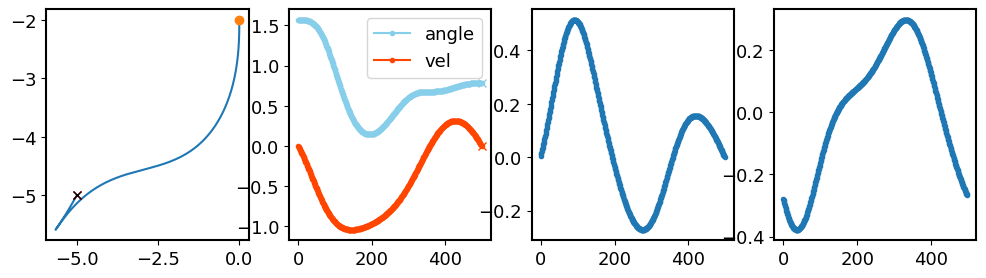

In [311]:
print(sls.x_nom[-1])
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(x_final_target[0], x_final_target[1], "rx")
ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")

ax[1].plot(sls.x_nom[:,2], "skyblue",marker=".", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", marker=".", label="vel")
ax[1].plot(N, x_final_target[2], "x", color="skyblue")
ax[1].plot(N, x_final_target[3], "x", color="orangered")


ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1], ".")

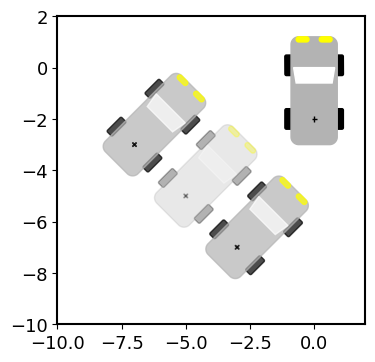

In [312]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
ln, = ax.plot([], lw=2, color="k")
ax.plot(sls.x_nom[:,0], sls.x_nom[:,1])
patches = plot_car(sls.x_nom[0], sls.u_nom[0], width=width_car, length=length_car)

width_car= 0.9
length_car =2.1
# Position of other two cars
xs_ = np.stack([np.array([-7., -3.]), np.array([-3., -7.])])

patches_final = plot_car(x_final_target, np.zeros(u_dim), width=width_car, length=length_car)
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
patches_car = plot_car(np.append(xs_[0], [x_final_target[2],0]), np.zeros(u_dim), width=width_car, length=length_car, bodycolor=[0.8,0.1,0])
for patch in patches_car:
    patch.set_alpha(0.7)
    ax.add_patch(patch)
    
patches_car = plot_car(np.append(xs_[1], [x_final_target[2],0]), np.zeros(u_dim), width=width_car, length=length_car, bodycolor=[0.8,0.1,0])
for patch in patches_car:
    patch.set_alpha(0.7)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-10, 2)
    ax.set_ylim(-10, 2)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[30:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::2], interval=20, init_func=init, blit=True)


## Solve the constrained problem

### Define constraints

In [347]:
list_of_proj_u = []
list_of_proj_x = []
# State limits
a_ = np.zeros((2,2)) # width, length
a_[0,:] = [2., 1.]
a_[1,:] = [2., 1.]
# a_safe = a_ + 0.1
a_safe = a_.copy()
a_safe[:,0] += 0.5
a_safe[:,1] += 0.5


Ws = np.zeros((2,2,2))
Ws[0] = np.diag(a_safe[0,0]/a_safe[0])
Ws[1] = np.diag(a_safe[1,0]/a_safe[1])

alpha = -np.pi/4
R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
Ws = Ws@R.T
Ws_inv = np.linalg.inv(Ws)

upper_sq = 1e5
lower_sq = a_safe[:,0]/2
def make_function(i):
    def f(y):
        y_ = y.reshape(N,d).copy()
        z = y_[:,:2] - xs_[i][None]
        z_projected = project_square_batch(z@Ws[i].T, lower_sq[i], upper_sq)
        z_projected = z_projected@Ws_inv[i].T
        y_[:,:2] = z_projected + xs_[i][None]
        return y_.flatten()
    return f


def project_y(x):
    x_ = x.reshape(N,d).copy()
    x_[:,1] = project_bound(x_[:,1],-6,10)
    return x_.flatten()
list_of_proj_x += [project_y]
    
# ### Control limits
# lower_u1 = -1.
# upper_u1 = 1.

# lower_u2 = -2.
# upper_u2 = 2.
# def project_u(u):
#     u_ = u.reshape(N,u_dim).copy()
#     u_[:, 0] = project_bound(u_[:, 0], lower_u1, upper_u1)
#     u_[:, 1] = project_bound(u_[:, 1], lower_u2, upper_u2)
#     return u_.flatten()

# list_of_proj_u += [project_u]

In [348]:
u0 = np.random.normal(size=(N, u_dim))*0.
x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]
sls.reset()
sls.nominal_values = x_nom, u_nom
sls.cost

3461.6850275068086

ADMM converged at iteration  3 !
ADMM residual is  0.00e+00 4.78e-02
Iteration number  0 iLQR cost:  2.267208346821838
ADMM converged at iteration  3 !
ADMM residual is  0.00e+00 4.89e-02
Iteration number  1 iLQR cost:  2.1173121736226137
ADMM converged at iteration  3 !
ADMM residual is  0.00e+00 4.15e-02
Iteration number  2 iLQR cost:  1.9841994580032094
ADMM converged at iteration  3 !
ADMM residual is  0.00e+00 8.54e-03
Iteration number  3 iLQR cost:  1.8619081800376853
ADMM can't improve anymore at iteration  2 !
ADMM residual is  0.00e+00 3.44e-01
ADMM residual change is  0.00e+00 3.54e-02
Iteration number  4 iLQR cost:  1.7301827679099877
ADMM can't improve anymore at iteration  2 !
ADMM residual is  0.00e+00 2.81e-01
ADMM residual change is  0.00e+00 4.81e-02
Iteration number  5 iLQR cost:  1.6037345524389162
ADMM can't improve anymore at iteration  2 !
ADMM residual is  0.00e+00 2.37e-01
ADMM residual change is  0.00e+00 4.37e-02
Iteration number  6 iLQR cost:  1.5077770292422

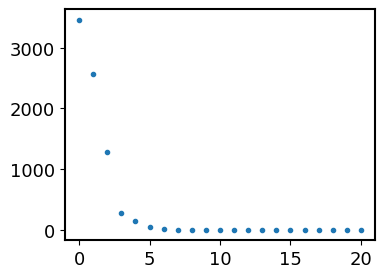

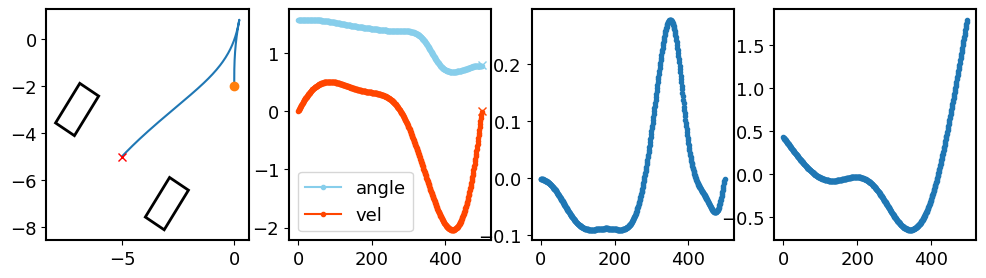

In [350]:
%%time
Rr = None
rho_x = np.zeros((N, d, d))
rho_x[:, :2, :2] = np.eye(2)*1e-1

alpha = 1. # relaxation parameter for ADMM
k_max = 10
log = sls.ilqr_admm(get_AB, list_of_proj_x=list_of_proj_x, list_of_proj_u=list_of_proj_u, max_admm_iter=10,
                        max_line_search=50, rho_x=rho_x, rho_u=Rr, alpha=alpha, k_max=k_max, threshold=1e-1, verbose=1, log=True)
plt.plot(sls.cost_log,".")
# plt.plot(log, ".")
print(sls.x_nom[-1])
fig,ax = plt.subplots(ncols=4, figsize=(12,3))
ax[0].plot()
ax[0].plot(sls.x_nom[:,0], sls.x_nom[:,1])
ax[0].plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
ax[0].plot(x_final_target[0], x_final_target[1], "rx")
# ax[0].plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")

ax[1].plot(sls.x_nom[:,2], "skyblue",marker=".", label="angle")
ax[1].plot(sls.x_nom[:,3], "orangered", marker=".", label="vel")
ax[1].plot(N, x_final_target[2], "x", color="skyblue")
ax[1].plot(N, x_final_target[3], "x", color="orangered")


ax[1].legend()

ax[2].plot(sls.u_nom[:-1,0], ".")
ax[3].plot(sls.u_nom[:-1,1], ".")

# lower_us = [lower_u1, lower_u2]
# upper_us = [upper_u1, upper_u2]

for i in range(2):
    
    sq = mpatches.Rectangle(xs_[i]-a_[i]/2, width=a_[i,0], height=a_[i,1], fill=False,lw=2, zorder=0,
                           transform=Affine2D().rotate_deg_around(*xs_[i], 180*alpha/np.pi)+ ax[0].transData)
    ax[0].add_patch(sq)

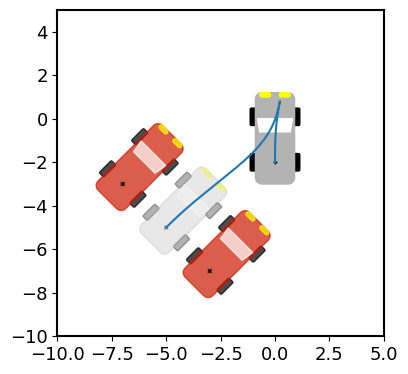

In [369]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(autoscale_on=False)
ax.set_aspect('equal')
# ax.grid()
ln, = ax.plot([], lw=2, color="k")
plt.tight_layout()
ax.plot(sls.x_nom[:,0], sls.x_nom[:,1])
# ax.plot(sls.x_nom[0,0], sls.x_nom[0,1], "o")
# ax.plot(sls.x_nom[-1,0]*0, sls.x_nom[-1,1]*0, "rx")
# ax.plot(sls.x_nom[-1,0], sls.x_nom[-1,1], "kx")


patches = plot_car(sls.x_nom[0], sls.u_nom[0], width=width_car, length=length_car)

width_car= 0.9
length_car =2.1
# Position of other two cars
xs_ = np.stack([np.array([-7., -3.]), np.array([-3., -7.])])

patches_final = plot_car(x_final_target, np.zeros(u_dim), width=width_car, length=length_car)
for patch in patches_final:
    patch.set_alpha(0.3)
    ax.add_patch(patch)
    
patches_car = plot_car(np.append(xs_[0], [x_final_target[2],0]), np.zeros(u_dim), width=width_car, length=length_car, bodycolor=[0.8,0.1,0])
for patch in patches_car:
    patch.set_alpha(0.7)
    ax.add_patch(patch)
    
patches_car = plot_car(np.append(xs_[1], [x_final_target[2],0]), np.zeros(u_dim), width=width_car, length=length_car, bodycolor=[0.8,0.1,0])
for patch in patches_car:
    patch.set_alpha(0.7)
    ax.add_patch(patch)
    
def init():
    ax.set_xlim(-10, 5)
    ax.set_ylim(-10, 5)

    for patch in patches:
        ax.add_patch(patch)
    return patches

def update(i):
    [p.remove() for p in reversed(ax.patches[30:])]
    patches = plot_car(sls.x_nom[i], sls.u_nom[i])
    for patch in patches:
        ax.add_patch(patch)
    return patches

ani = FuncAnimation(fig, update, frames=np.arange(N)[::4], interval=20, init_func=init, blit=True)


In [372]:
# ani.save('animation_state_bounds.gif', writer='imagemagick', fps=60)